In [35]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from awave.experimental.filters import gabor_filter, edge_filter, curve_filter
from awave.experimental.filters_agg import *
import awave.experimental.viz as viz
from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# look at base filters

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 4764.45it/s]


(90, 1, 7, 7)


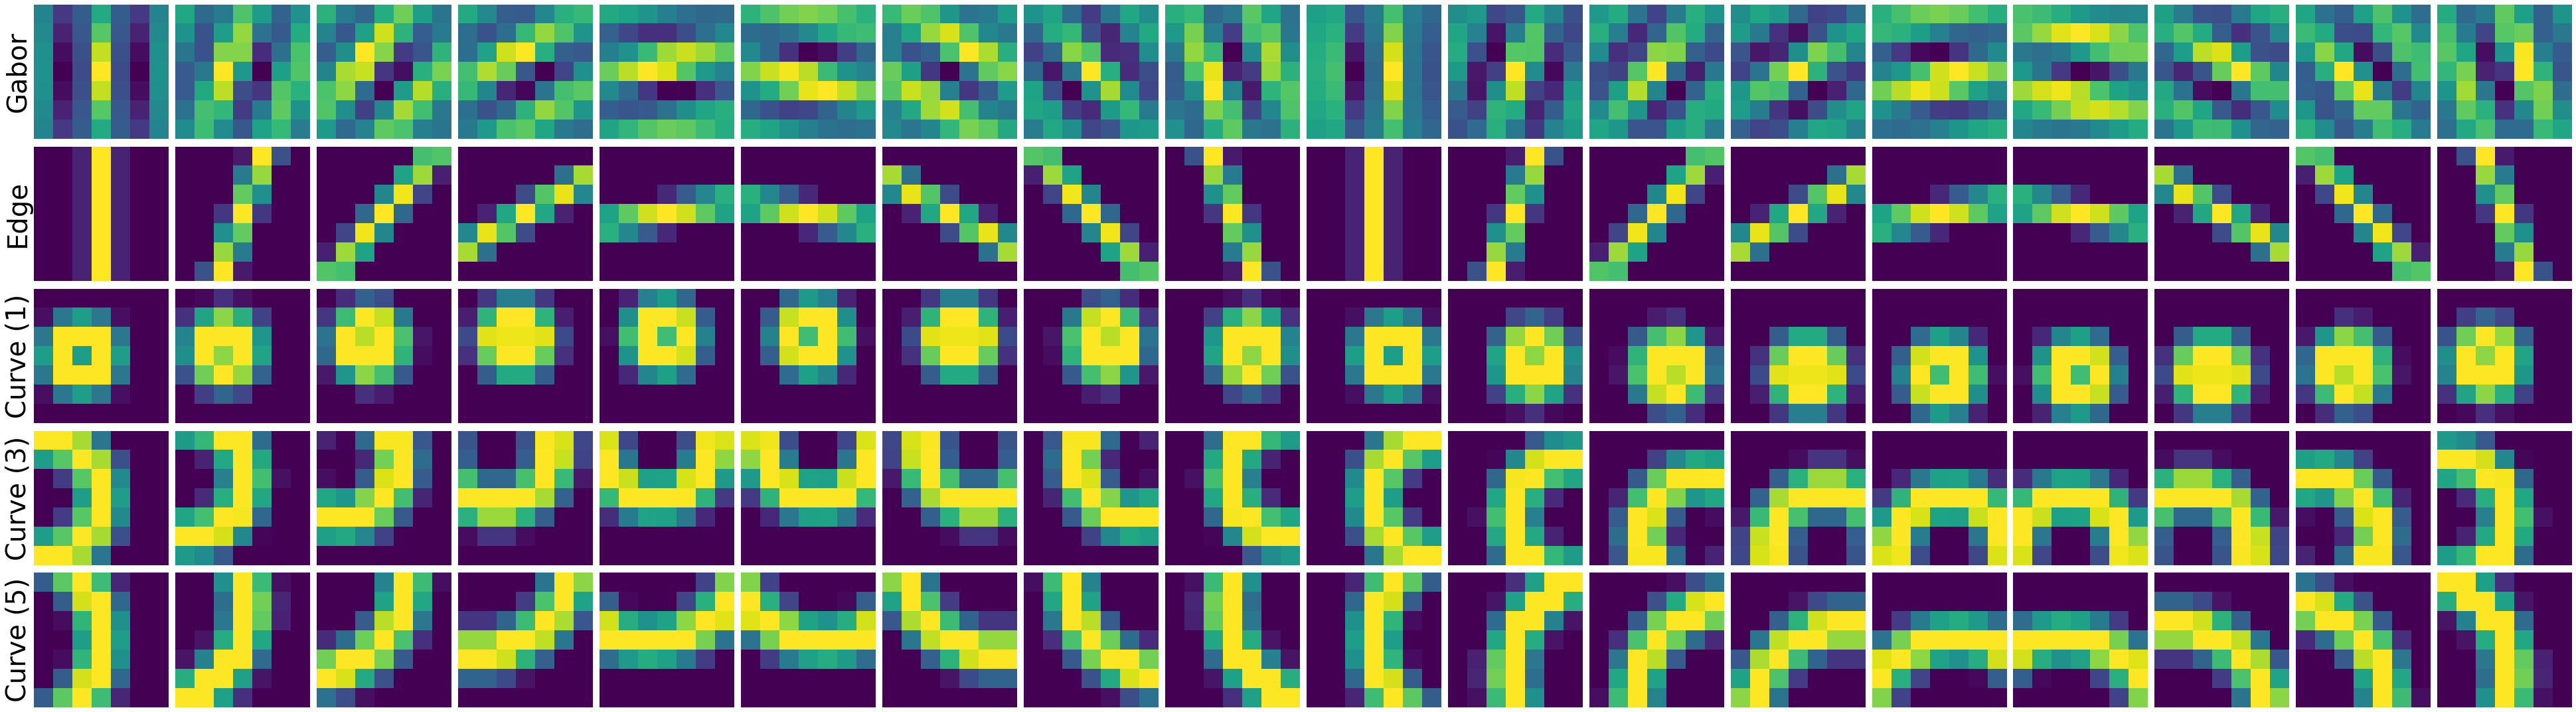

In [40]:
filter_size = 7
angle_step = 20
ims = []
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(gabor_filter(filter_size, angle), 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(edge_filter(filter_size, angle)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(curve_filter(filter_size, angle, radius=1)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(curve_filter(filter_size, angle, radius=3)[0], 0))
for angle in tqdm(range(0, 360, angle_step)):
    ims.append(np.expand_dims(curve_filter(filter_size, angle, radius=5)[0], 0))

print('Note the curve filter has a radius paramter which can be easily optimized...')
viz.plot_grid(ims, ylabs=['Gabor', 'Edge', 'Curve (1)', 'Curve (3)', 'Curve (5)'], fontsize_ylab=40)

# stitch together base filters

In [2]:
input_spec    = [("color", i) for i in range(3)]
conv2d0_spec  = [("gabor", orientation,  offset) for orientation in range(0, 180, 10) for offset in [0, 7./8., 7./4, 7.*3/8.]]
conv2d1_spec  = [("edge", orientation) for orientation in range(0, 180, 10) ]

conv2d2_spec  = [("curve", orientation) for orientation in range(0, 360, 15) ]
conv2d2_spec += [("edge",  orientation) for orientation in range(0, 180, 10) ]

mixed3a_spec  = [("curve", orientation) for orientation in range(0, 360, 15) ]
mixed3a_spec += [("edge",  orientation) for orientation in range(0, 180, 10) ]

mixed3b_spec  = [("curve", orientation) for orientation in range(0, 360, 15) ]
mixed3b_spec += [("edge",  orientation) for orientation in range(0, 180, 10) ]

In [4]:
_warned = []


def make_weight_connection(size, in_spec, out_spec, r=None):
    if in_spec[0] == "color" and out_spec[0] == "gabor":
        F = gabor_filter(size, ang=out_spec[1], shift=out_spec[2])

    elif in_spec[0] in ("gabor", "edge") and out_spec[0] == "edge":
        F = edge_edge_connect(size, ang1=in_spec[1], ang2=out_spec[1])

    elif in_spec[0] == "edge" and out_spec[0] == "curve":
        assert r != None
        F = edge_curve_connect(size, ang1=in_spec[1], ang2=out_spec[1], r=r)

    elif in_spec[0] == "curve" and out_spec[0] == "curve":
        assert r != None
        F = curve_curve_connect(size, ang1=in_spec[1], ang2=out_spec[1], r=r)

    else:
        if (in_spec[0], out_spec[0]) not in _warned:
            print("Warning: no registered map", in_spec[0], out_spec[0])
            _warned.append((in_spec[0], out_spec[0]))
        F = np.zeros([size, size])
    return F[..., None, None]


def make_weights(size, in_specs, out_specs, r=None):
    W = np.concatenate([
        np.concatenate([make_weight_connection(size, in_spec, out_spec, r=r) for in_spec in in_specs], axis=-2)
        for out_spec in out_specs], axis=-1)
    # W /= np.sqrt((W**2).sum(axis=(0,1,2), keepdims=True) + 1e-3)
    return W

In [9]:
W_conv2d0 = make_weights(7, input_spec, conv2d0_spec)
W_conv2d1 = make_weights(1, conv2d0_spec, conv2d1_spec)
W_conv2d2 = make_weights(3, conv2d1_spec, conv2d2_spec, r=list(range(5,10)))
W_mixed3a = make_weights(3, conv2d2_spec, mixed3a_spec, r=list(range(4,10)))
W_mixed3b = make_weights(5, mixed3a_spec, mixed3b_spec, r=list(range(4,10)))

In [12]:
W_conv2d0.shape

(7, 7, 3, 72)

# set up architecture based on these weights

In [10]:
t_image = tf.placeholder("float32", [None, None, None, 3], name="input")

t_conv2d0 = tf.nn.conv2d(t_image, W_conv2d0, strides=[2,2], padding="SAME")
t_conv2d0 = tf.nn.relu(t_conv2d0, name="conv2d0")

t_conv2d0_pool = tf.nn.max_pool2d(t_conv2d0, [3,3], strides=[2,2], padding="SAME")

t_conv2d1 = tf.nn.conv2d(t_conv2d0_pool, W_conv2d1, strides=[1,1], padding="SAME")
t_conv2d1 = tf.nn.relu(t_conv2d1, name="conv2d1")

t_conv2d2 = tf.nn.conv2d(t_conv2d1, W_conv2d2, strides=[1,1], padding="SAME")
t_conv2d2 = tf.nn.relu(t_conv2d2, name="conv2d2")

t_conv2d2_pool = tf.nn.max_pool2d(t_conv2d2, [3,3], strides=[2,2], padding="SAME")

t_mixed3a = tf.nn.conv2d(t_conv2d2_pool, W_mixed3a, strides=[1,1], padding="SAME")
t_mixed3a = tf.nn.relu(t_mixed3a, name="mixed3a")

t_mixed3b = tf.nn.conv2d(t_mixed3a, W_mixed3b, strides=[1,1], padding="SAME")
t_mixed3b = tf.nn.relu(t_mixed3b, name="mixed3b")

NameError: name 'tf' is not defined